<a href="https://colab.research.google.com/github/TMQ5/my_projects/blob/main/stc_TV_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STC Jawwy

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
%cd '/content/drive/My Drive/Task2_STC_TV/'
%ls

/content/drive/My Drive/Task2_STC_TV
'stc TV Data Set_T2 .xlsx'  'stc TV_T2.ipynb'


In [109]:
'''
Here we install libraries that are not installed by default
Example:  pyslsb
Feel free to add any library you are planning to use.
'''
!pip install pyxlsb

In [110]:
# Import the required libraries
'''
Please feel free to import any required libraries as per your needs
'''
import pandas as pd     # provides high-performance, easy to use structures and data analysis tools
import pyxlsb           # Excel extention to read xlsb files (the input file)
import numpy as np      # provides fast mathematical computation on arrays and matrices
import scipy.stats as stats
import matplotlib.pyplot as plt # a comprehensive library for creating static, animated, and interactive visualizations
import plotly #a graphing library makes interactive, publication-quality graphs. Examples of how to make line plots, scatter plots, area charts, bar charts, error bars, box plots, histograms, heatmaps, subplots, multiple-axes, polar charts, and bubble charts.
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


# Jawwy dataset
The dataset includes total watching hours for customers per day.

You are required to work on predecting the forecast for the watching hours.

In [111]:
# Read data from an Excel file into a DataFrame
dataframe = pd.read_excel('stc TV Data Set_T2 .xlsx',index_col=0)


In [112]:
# Display the first 10 rows of the DataFrame
dataframe.head(10)

,date_,Total_watch_time_in_houres
0,2018-01-01,1123.551944
1,2018-01-02,1000.129722
2,2018-01-03,881.924444
3,2018-01-04,782.669444
4,2018-01-05,1051.939444
5,2018-01-08,841.178333
6,2018-01-09,873.495000
7,2018-01-10,970.475000
8,2018-01-11,721.381944
9,2018-01-12,772.675000


In [113]:
# Display the last 10 rows of the DataFrame
dataframe.tail(10)

,date_,Total_watch_time_in_houres
76,2018-04-17,750.944444
77,2018-04-18,566.104444
78,2018-04-19,586.404444
79,2018-04-20,700.296667
80,2018-04-23,670.885556
81,2018-04-24,652.625278
82,2018-04-25,650.428889
83,2018-04-26,675.184444
84,2018-04-27,601.738056
85,2018-04-30,609.281667


# Data Preprocessing on the input data

In [114]:
# Please make a copy of dataset if you are going to work directly and make changes on the dataset
df=dataframe.copy()

In [115]:
# Check the data shape
dataframe.shape

(86, 2)

The DataFrame contains 86 rows and two columns.

In [116]:
# Print the data types for each columns in the Dataframe
dataframe.dtypes

date_                         datetime64[ns]
Total_watch_time_in_houres           float64
dtype: object

The data types are suitable for the predictive analysis that we will perform.

- The watching **date_** type is **datetime64[ns]**, which is ideal for time series data as it facilitates working with dates and times. This includes grouping data by day, week, or month and performing calculations related to time periods. Such capabilities are essential for analyzing time trends and identifying periodic patterns, such as the peak times we need to determine in this task.

- The **float64** data type for **Total_watch_time_in_houres** is also appropriate since representing watching hours as a decimal maintains accuracy, particularly when accounting for minutes or seconds as fractions of an hour. This precision is crucial in analytics for accurately evaluating watching time to understand user behavior. We do not need to change the data type; converting the data to an integer would omit fine details, such as veiwing that do not complete a full hour, potentially compromising the accuracy of our analysis and predictions.

In [117]:
# check if any column has null value in the dataset
dataframe.isnull().any()

date_                         False
Total_watch_time_in_houres    False
dtype: bool

In [118]:
# Describe the numeric values in the dataset
dataframe.describe()

,date_,Total_watch_time_in_houres
count,86,86.000000
mean,2018-02-28 17:01:23.720930304,780.817926
min,2018-01-01 00:00:00,562.124722
25%,2018-01-30 06:00:00,707.709653
50%,2018-02-28 12:00:00,763.181389
75%,2018-03-29 18:00:00,840.985278
max,2018-04-30 00:00:00,1123.551944
std,NaN,122.992002


From this statistical summary we notes 2 things:
- `There are missing days`:
the earliest date is January 1, 2018 and the latest date is April 30, 2018. This period extends to 120 days. However, the date_ column has only 86 rows, indicating gaps in the data. This discrepancy suggests that there may not be records for every day during this period; Instead, records exist for only 86 days. This may be due to missing data or errors in data collection or recording, resulting in it not being documented on some days.


We will check the dates and identify any missing days and address them if possible.

In [119]:
# Define the full range of expected dates from January 1, 2018 to April 30, 2018
all_dates = pd.date_range(start='2018-01-01', end='2018-04-30')

# Check for any dates that are not present in the 'date_' column of the dataframe
missing_dates = all_dates[~all_dates.isin(dataframe['date_'])]

# Print the missing dates
print("Missing dates:")
print(missing_dates)

# Print the number of missing days
print("Number of missing days:", len(missing_dates))

Missing dates:
DatetimeIndex(['2018-01-06', '2018-01-07', '2018-01-13', '2018-01-14',
               '2018-01-20', '2018-01-21', '2018-01-27', '2018-01-28',
               '2018-02-03', '2018-02-04', '2018-02-10', '2018-02-11',
               '2018-02-17', '2018-02-18', '2018-02-24', '2018-02-25',
               '2018-03-03', '2018-03-04', '2018-03-10', '2018-03-11',
               '2018-03-17', '2018-03-18', '2018-03-24', '2018-03-25',
               '2018-03-31', '2018-04-01', '2018-04-07', '2018-04-08',
               '2018-04-14', '2018-04-15', '2018-04-21', '2018-04-22',
               '2018-04-28', '2018-04-29'],
              dtype='datetime64[ns]', freq=None)
Number of missing days: 34


As we expected, there were 34 days missing out of 120 days.

We will need to evaluate the impact of these missing days on the predictive analysis that we will perform.

**First: Are these days official holidays in Saudi Arabia?**

In [120]:
# Import the holidays library for working with public holidays
import holidays

# Create a list of public holidays in Saudi Arabia for the year 2018
sa_holidays = holidays.SaudiArabia(years=[2018])

# Create a list of missing dates that are public holidays by checking each missing date against the list of holidays
missing_dates_holidays = [date for date in missing_dates if date in sa_holidays]

In [121]:
# Print the list of holiday dates
list(sa_holidays)

[datetime.date(2018, 6, 15),
 datetime.date(2018, 6, 16),
 datetime.date(2018, 6, 17),
 datetime.date(2018, 6, 18),
 datetime.date(2018, 6, 19),
 datetime.date(2018, 6, 20),
 datetime.date(2018, 8, 20),
 datetime.date(2018, 8, 21),
 datetime.date(2018, 8, 22),
 datetime.date(2018, 8, 23),
 datetime.date(2018, 9, 23)]

We can see that the Saudi holidays in 2018 are not among the missing days, where the official holidays in Saudi Arabia were in June, August, and September and the missing days are in between January and April. This suggests that the missing dates do not coincide with these public holidays.



**Second: Does it occur on specific days of the week, such as weekends?**

In [122]:
# Create a DataFrame from the missing_dates (DatetimeIndex of dates)
df_missing = pd.DataFrame(missing_dates, columns=['date_'])

# Calculate the day of the week for each date in the DataFrame
df['day_of_week'] = df_missing['date_'].dt.day_name()

# Count the occurrences of each day of the week
day_counts = df['day_of_week'].value_counts()

# Print the distribution of missing days by day of the week
print("Distribution of missing days by day of the week:")
day_counts

Distribution of missing days by day of the week:


day_of_week
Saturday    17
Sunday      17
Name: count, dtype: int64

The missing days are Saturday and Sunday, meaning that the missing days included a weekend day (Saturday) and a non-holiday day (Sunday).

This may affect the data analysis, especially since the number of hours of watching programs may differ significantly between weekdays and weekends. Weekends may show different behaviors or trends compared to weekdays. For example, recreational activities or pastimes may increase on weekends. Ignoring this can bias the conclusions drawn from the data.



**Third: Calculate the percentage of days missing**

The formula for calculating the percentage of missing days is:

\

\

$$
\text{Percentage of Missing Days} = \left( \frac{\mathbf{n} \text{ (the number of missing days)}}{\mathbf{N} \text{ (the total number of days in the period)}} \right) \times 100\%
$$

\

\


$$
\text{Percentage of Missing Days} = \left( \frac{34}{120}\right) \times 100\% = 28.33\%
$$

The 28.33% rate of missing days is relatively high. In other words, losing approximately one-third of the data during the specified period can have a significant impact on the results and analyzes drawn from this data.

***Sum Up:***

We defined the missing days as occurring on Saturdays and Sundays, which "Saturdays" are considered weekend days in Saudi Arabia. These missing days represent a large portion of our dataset, amounting to one-third of the total days. This high percentage of missing data will likely affect the accuracy of the predictive models we plan to build.


\



---


- `There are ouliers`the statistical summary of the total watch time in hours for programs on the STC TV application indicates that the average daily watch time is approximately 780.82 hours, with significant variability as evidenced by a standard deviation of 122.99 hours. The range of recorded watching days extents from a minimum of 562.12 hours to a maximum of 1,123.55 hours, reflecting substantial day-to-day variation in the popularity of the programs.

\


We will confirm whether there are outliers values that affect the analysis result or not:

\

**First: Distribution of Watch Time in Hours**

We will plot a histogram of the data to visualize its distribution and then determine the most appropriate method for identifying outliers, whether it be the standard deviation method or the interquartile range (IQR).

If the data follows a normal distribution, or is nearly normal, the standard deviation method may be both effective and accurate. However, for data that is not symmetrical or contains numerous outliers, the IQR method is a better option as it provides a more reliable estimate of variability.

In [123]:
# Creating a histogram of the 'Total_watch_time_in_houres' column from the 'dataframe'.
fig = px.histogram(dataframe, x='Total_watch_time_in_houres', nbins=30, title='Histogram of Total Watch Time in Hours')

# Updating the layout of the histogram:
fig.update_layout(
    xaxis_title='Total Watch Time in Hours',
    yaxis_title='Frequency',
    bargap=0.2)

# Displaying the figure
fig.show()

In [124]:
# Shapiro-Wilk Test
data = dataframe['Total_watch_time_in_houres']
stat, p = stats.shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpreting the test result
if p > 0.05:
    print('Data appears to be normally distributed')
else:
    print('Data does not appear to be normally distributed')

Statistics=0.969, p=0.036
Data does not appear to be normally distributed


I analyzed the data using a *histogram* and also performed a *Shapiro-Wilk test* to confirm the distribution results. Both methods indicated that the `distribution was asymmetric`.

\

**Second: Use Interquartile Range (IQR) to Identify Outliers**

We will use box plot that gives a visual representation of the quartile distribution of data and helps identify outliers based on calculations related to the quartiles.

In [125]:
# Initializing an empty figure object to build the plot upon.
fig = go.Figure()

# Adding a boxplot trace to the figure. This boxplot represents the distribution of total watch times in hours.
fig.add_trace(go.Box(y=dataframe['Total_watch_time_in_houres'], name='Watch Time'))

# Updating the layout of the figure to include titles and axis labels:
fig.update_layout(title='Boxplot of Total Watch Time in Hours',
                  yaxis_title='Hours',
                  xaxis_title='Programs',
                  showlegend=True)

# Displaying the figure
fig.show()

`The values of this boxplot are:`  
- **Min:** The lowest value in the data is 562.1247.

- **First quartile (Q1):** The value that separates the bottom 25% of the data, which is 707.3611.

- **The second quartile (Q2) or (Median):** The value that divides the data into two equal halves, which is 763.1814.

- **Third quartile (Q3):** The value that separates the top 25% of the data, which is 841.1783.

- **Upper limit:** It is the upper limit of the data without outliers, which is 1025.596.

- **Max:** The highest value in the data, which is 1123.552.

\

`Identify outliers:`

Outliers in a box plot are identified based on the difference between the first quartile (Q1) and the third quartile (Q3), known as the interquartile range (IQR).

\

$$
\text{IQR} = Q3 - Q1 \\
\text{where: } Q3 \text{ is the third quartile (75th percentile),} \\
\text{and } Q1 \text{ is the first quartile (25th percentile).}
$$

\

$$
\begin{align*}
\text{IQR (Interquartile Range)} &= Q3 - Q1 = 841.1783 - 707.3611 = 133.8172 \\
\text{Minimum Outlier} &= Q1 - 1.5 \times \text{IQR} = 707.3611 - (1.5 \times 133.8172) = 507.1333 \\
\text{Upper Limit of Outliers} &= Q3 + 1.5 \times \text{IQR} = 841.1783 + (1.5 \times 133.8172) = 1041.4061
\end{align*}
$$

\

Based on BoxPlot analysis, outliers were identified in our data. Whereas, outliers are defined as those that exceed the limits defined by the first quartile (Q1) and third quartile (Q3) by more than 1.5 times the interquartile range (IQR).

1.   Upper Outlier Limit: It was calculated to be equal to 1041.4061.
2.   Lower Outlier Limit: It was calculated to be equal to 507.1333.


We notice the presence of three outliers:
- Maximum value (1123.552)
- Specific one, which is (1053.169)
- And another one (1051.939444)

These are values that exceed the upper limit of outliers, and there are no values that fall below the lower limit of outliers, which means that all lower values are within the normal range of the distribution.





In [126]:
# Calculate the first quartile (25th percentile) and the third quartile (75th percentile) of the total watch time in hours
# Then compute the Interquartile Range (IQR) as the difference between Q3 and Q1
Q1 = dataframe['Total_watch_time_in_houres'].quantile(0.25)
Q3 = dataframe['Total_watch_time_in_houres'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bound to identify outliers below and above it
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter and obtain rows where the watch time is either below the lower bound or above the upper bound
outliers = dataframe[(dataframe['Total_watch_time_in_houres'] > upper_bound )| (dataframe['Total_watch_time_in_houres'] < lower_bound)]

# Display the outliers
outliers

,date_,Total_watch_time_in_houres
0,2018-01-01,1123.551944
4,2018-01-05,1051.939444
23,2018-02-01,1053.168611


***Sum Up:***

Statistical analysis of the Total_watch_time_in_houres column revealed variation in the popularity of programs day after day. Three outliers were precisely identified on the following dates:

- January 1, 2018

- February 1, 2018

- May 1, 2018

Due to the small size of the data (86 rows), these outliers may affect analyzes if not handled correctly. After research and investigation, we did not find specific events or the launch of new programs that may have affected the number of watching hours. Therefore, this could be part of the random variation and fluctuations in the data or due to other factors that we could not clearly identify.


In [127]:
# Setting the date as index
dataframe.set_index('date_', inplace=True)

In [128]:
# Display the dataframe after setting the date as index
dataframe.head()

,Total_watch_time_in_houres
date_,
2018-01-01,1123.551944
2018-01-02,1000.129722
2018-01-03,881.924444
2018-01-04,782.669444
2018-01-05,1051.939444


In [129]:
# Create a line plot for 'Total_watch_time_in_houres' across the dates
fig = px.line(dataframe,  y="Total_watch_time_in_houres")

# Update the layout of the figure to include titles and axis labels
fig.update_layout(
    title="Total Watch Time in Hours Over Time",
    xaxis_title="Date",
    yaxis_title="Total Watch Time in Hours",
    xaxis=dict(
        title="Date"))

# Show the figure
fig.show()

# Predictive Models

<h1>Prophet Predicative Model</h1>


In [130]:
"""
TODO using the previous dataset (df) build a prediction model to predict the expected watch time for the next two months
Hint: you can build a forecast model to predict the results
"""

'\nTODO using the previous dataset (df) build a prediction model to predict the expected watch time for the next two months\nHint: you can build a forecast model to predict the results\n'

In [131]:
# Reset the index of the dataframe to turn the 'date_' column back into a regular column
dataframe.reset_index(inplace=True)

# Rename the columns for compatibility with the Prophet forecasting library
# 'date_' is renamed to 'ds' (datestamp) and 'Total_watch_time_in_houres' to 'y' (target variable)
dataframe.rename(columns={'date_': 'ds', 'Total_watch_time_in_houres': 'y'}, inplace=True)

# Display the dataframe to verify the changes
dataframe

,ds,y
0,2018-01-01,1123.551944
1,2018-01-02,1000.129722
2,2018-01-03,881.924444
3,2018-01-04,782.669444
4,2018-01-05,1051.939444
...,...,...
81,2018-04-24,652.625278
82,2018-04-25,650.428889
83,2018-04-26,675.184444
84,2018-04-27,601.738056


In [132]:
# Create a new Prophet model instance
model = Prophet()

# Add built-in country holidays for Saudi Arabia to the model
# This will allow the model to account for potential impacts of public holidays on the forecast
model.add_country_holidays(country_name='SA')

# Fit the model to the dataframe
model.fit(dataframe)

# Perform cross-validation to measure forecast error using historical data
df_cv = cross_validation(model, initial='60 days', period='15 days', horizon = '12 days')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgueaaaa8/6ausd9sz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgueaaaa8/sc286y_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33840', 'data', 'file=/tmp/tmpgueaaaa8/6ausd9sz.json', 'init=/tmp/tmpgueaaaa8/sc286y_a.json', 'output', 'file=/tmp/tmpgueaaaa8/prophet_model626ub1b2/prophet_model-20240504214015.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:40:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cu

  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgueaaaa8/_9j61zrw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgueaaaa8/5pc9q1ps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76393', 'data', 'file=/tmp/tmpgueaaaa8/_9j61zrw.json', 'init=/tmp/tmpgueaaaa8/5pc9q1ps.json', 'output', 'file=/tmp/tmpgueaaaa8/prophet_modelfc4bnur6/prophet_model-20240504214016.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgueaaaa8/nxcuuuqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgueaaaa8/j7t3m39d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [133]:
# Print the list of holidays recognized by the model for the specified country ('SA' for Saudi Arabia)
model.train_holiday_names

0              Eid al-Fitr Holiday (estimated)
1    Eid al-Fitr Holiday (observed, estimated)
2                       Arafat Day (estimated)
3              Eid al-Adha Holiday (estimated)
4                         National Day Holiday
dtype: object

In [134]:
# Create a dataframe for future dates extending 60 days beyond the last date in the original dataset
future = model.make_future_dataframe(periods=60)

# Use the model to predict values for the future dates (Next 2 months)
forecast = model.predict(future)

# Filter the forecast to only include dates after April 30, 2018
forecast_filtered = forecast[forecast['ds'] > '2018-04-30']
forecast_filtered[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
86,2018-05-01,641.705757,524.109319,765.444024
87,2018-05-02,622.752678,500.074207,747.423711
88,2018-05-03,624.402897,501.917497,740.967687
89,2018-05-04,650.397380,533.136170,765.695526
90,2018-05-05,-790.488724,-911.277688,-670.521796
91,2018-05-06,-792.766793,-915.730801,-672.388555
92,2018-05-07,638.672636,518.600670,761.618383
93,2018-05-08,625.758787,503.882949,739.630060
94,2018-05-09,606.805708,486.944765,722.434764
95,2018-05-10,608.455927,490.532985,729.514369


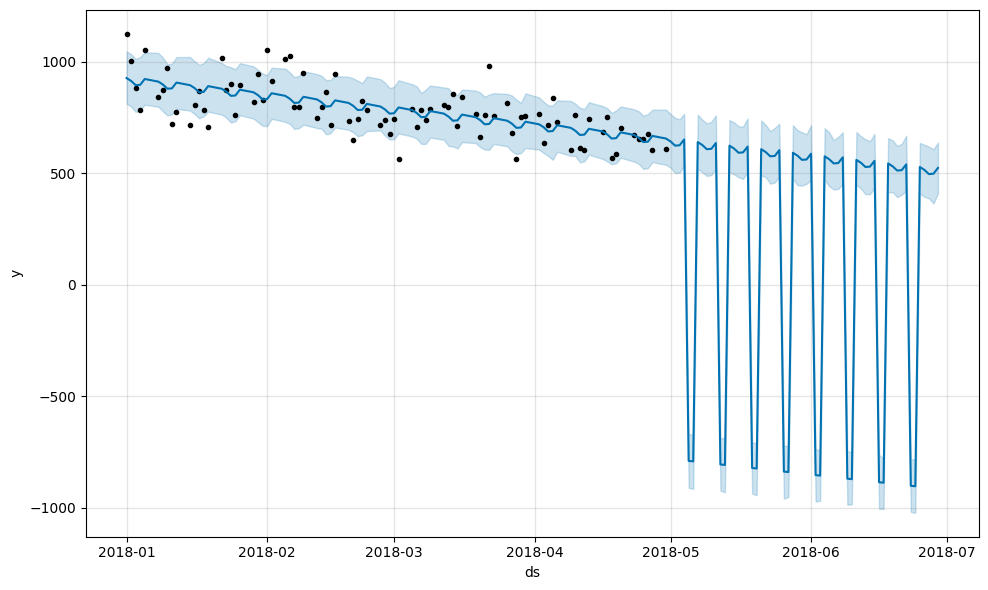

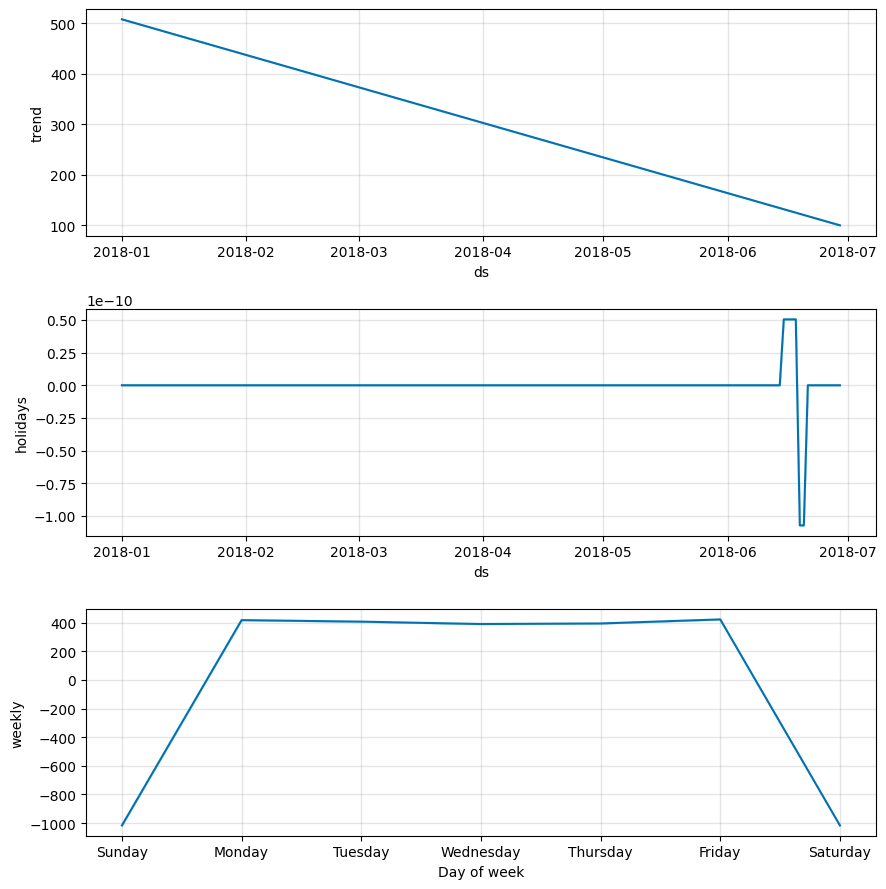

In [135]:
# Plotting the forecasted values
fig1 = model.plot(forecast)

# Displaying components of the forecast (trends and seasonality)
fig2 = model.plot_components(forecast)

**Interpreting the components in the Prophet model:**

`1- Trend Component:`

We observed a continuous decline in watching hours from January to June. This decline reflects a general decrease in watching hours over the months. It may be advisable to gather user feedback for the STC TV app, analyze ratings and reviews, and monitor market changes to discover the reasons for this decline.

\

`2- Holidays Component:`

The holiday component in the Prophet model reflects the impact of these days on the predictive model. The chart shows that there were no significant effects from holidays on the number of watching hours from January to mid-June, and any fluctuations in the data would be due to other factors besides holidays. After mid-June, there was a relative increase indicating the presence of a holiday or specific event that had a noticeable and positive impact on watching behaviors and watching hours. This event attracted greater interest and an increase in viewership. Research revealed that the event in mid-June 2018 was *Eid al-Fitr* and its associated holiday, likely causing many people to spend more time at home watching television, thereby increasing the demand for entertainment content. It is advisable to engage in strategic content and marketing planning, enabling better exploitation of such periods by intensifying promotional offers or presenting attractive content that aligns with the general atmosphere of the holiday. Additionally, predictive models can be improved by integrating variables related to holidays to enhance the accuracy of predictions during such periods.

\

`3- Weakly Component:`

The weekly component in the Prophet model reflects how watching hours typically change across the days of the week. We observe that Saturdays and Sundays are notably below zero compared to the other days, which show around 400 watching hours. The relatively high levels during other days indicate a stability or an increase in usual usage, suggesting a consistent daily routine of viewers during workdays. It is advisable to seize the opportunity to enhance the promotion of engaging or exclusive content during Saturdays and Sundays to attract viewers on these days.

- *It is important to note that there were 34 missing days, previously mentioned during the data processing, which occurred on Saturdays and Sundays. The predictive model may have been influenced by the absence of data on these days in the original dataset. The lack of data for these days can lead to inaccurate or misleading estimates for those days, as the model assumes certain patterns based on the data available from other days. This means that predictions for Saturdays and Sundays may not be reliable enough due to the lack of data for these days in the original sample.*








In [136]:
# Create a plot using Plotly with the predicted values.
fig = go.Figure([go.Scatter(name='Predicted',
                            x=forecast['ds'],
                            y=forecast['yhat'],
                            mode='lines',
                            line=dict(color='blue'),
                            showlegend=True),

    go.Scatter(name='Upper Bound',
               x=forecast['ds'],
               y=forecast['yhat_upper'],
               mode='lines',
               marker=dict(color='#444'),
               line=dict(width=0),
               showlegend=False),

    go.Scatter(name='Lower Bound',
               x=forecast['ds'],
               y=forecast['yhat_lower'],
               marker=dict(color="#444"),
               line=dict(width=0),
               mode='lines',
               fillcolor='rgba(68, 68, 68, 0.3)',
               fill='tonexty',
               showlegend=False)])


fig.update_layout(
    title='Forecast of Watching Hours with Confidence Interval',
    xaxis_title='Date',
    yaxis_title='Watching Hours',
    hovermode='x')

fig.show()

In the provided chart, we observe predictions for the number of watching hours on the STC TV app over the coming months. The blue line represents daily predictions for watching hours, showing a general trend of decline during the analyzed period. It is noteworthy that there are significant and recurring decreases in predictions coinciding with Saturdays and Sundays each week, reflecting a drop in viewership on these days. It is important to note that these periodic declines during Saturdays and Sundays could be due to the lack of data for these days in the original sample, which may affect the accuracy of predictions for these periods. This lack of data should be considered when planning promotional activities or future analyses.

Based on these observations, it is advisable to optimize the timing and content of promotional offers to enhance engagement during days with low viewership, especially during weekends. It is also recommended to continue monitoring patterns and updating the model with any new data available to ensure the accuracy and effectiveness of the predictions.

In [137]:
# Filters out days where the predicted watch hours are above the average predicted watch hours, suggesting these are potential peak days.
peak_days = forecast_filtered[forecast_filtered['yhat'] > forecast_filtered['yhat'].mean()]

# Prints the count of potential peak days to help identify periods with higher expected viewer engagement.
print('The Number of Potential Peak Days is:')
print(peak_days.shape[0])

# Displays the dates and predicted watch hours for the identified peak days.
print('The Potential Peak Days in the Future:')
peak_days[['ds', 'yhat']]

The Number of Potential Peak Days is:
44
The Potential Peak Days in the Future:


,ds,yhat
86,2018-05-01,641.705757
87,2018-05-02,622.752678
88,2018-05-03,624.402897
89,2018-05-04,650.397380
92,2018-05-07,638.672636
93,2018-05-08,625.758787
94,2018-05-09,606.805708
95,2018-05-10,608.455927
96,2018-05-11,634.450409
99,2018-05-14,622.725666


There are 44 days out of 60 that will be peak days.

**Conclusion**

In this project, we embarked on the task of forecasting the expected watch hours for STC TV app users over the next two months, aiming to identify potential peak times. Utilizing the Prophet forecasting model, we analyzed the daily watch hours from January 1, 2018, to April 30, 2018, a dataset that initially comprised 120 days but had 34 missing values, particularly on weekends (Saturdays and Sundays).

\

The predictive analysis revealed a general downward trend in watch hours over the months. Particularly notable was the consistent drop in watch hours during weekends, which can be attributed to the lack of data for these days in the original dataset. This absence likely skewed the model’s accuracy for these specific days, suggesting that the weekend forecasts may not be reliable. Additionally, the model indicated intermittent peaks, which were not aligned with actual events or holidays, suggesting anomalies or potential data recording errors.

\

To enhance the promotional strategies and content planning of STC TV, it is recommended to:

- **Improve Data Collection:** Enhance the data collection methods to ensure that no days are missing from the analysis, especially weekends when different viewing patterns might emerge.
- **Refine the Model:** Continuously update the forecasting model with new data as it becomes available and consider adjusting for known holidays or events that could influence viewing patterns.
- **Target Promotions:** Strategically plan promotions during predicted lower viewing periods to increase engagement and potentially smooth out fluctuations in watch hours.

\

Furthermore, the analysis underscored the importance of considering data completeness and accuracy in predictive modeling. Future models should incorporate a more robust handling of missing data and potentially use additional or alternative models such as ARIMA or SARIMA for comparative analysis to ensure the robustness and reliability of the forecasts.

\

By addressing these recommendations, STC TV can better align its business strategies with viewer behavior, optimizing both viewer engagement and content delivery. Continuous monitoring and model adjustments based on updated data and feedback will be crucial for maintaining the accuracy and relevance of the predictions.